Analyzing a BIOCHROSE replica exchange simulation
=================================================

For more challenging (in terms of number of beads) systems, it is highly recommended to embed the Gibbs sampler in a Replica Exchange (RE, Swendsen and Wang (1986)) scheme. In the case of an ISD simulation this means that we're not only simulating the posterior distribution, but also "flatter" versions of it. In BIOCHROSE, we introduce two temperature-like parameters, $\lambda$ and $\beta$, which serve to adjust the influence of the likelihood and the volume exclusion, respectively. The simulation output is thus not only samples from the posterior distribution ($\lambda = \beta = 1$), but also from the "flatter" versions with $\lambda < 1$ and / or $\beta < 1$.
As an example, we will now analyze a RE simulation, in which the $C_{\alpha}$ positions of two proteins are infered from simulated data.

Let's start by parsing the config file:

In [8]:
from ensemble_hic.setup_functions import parse_config_file
config_file = 'RE_proteins_config.cfg'
settings = parse_config_file(config_file)
    

Let's extract some settings we'll need in the next step:

In [9]:
output_folder = settings['general']['output_folder']
n_replicas = int(settings['replica']['n_replicas'])
dump_interval = int(settings['replica']['samples_dump_interval'])
n_samples = int(settings['replica']['n_samples'])
schedule_file = settings['replica']['schedule']

We now use the helper function ``load_samples`` to... well... load (a subset of) samples from all replicas. You could also use ``load_sr_samples`` to load samples of only a single replica or ``load_samples_from_cfg`` to conveniently load posterior samples directly using only the config file. Note that if ``n_samples`` is not the actual number of samples drawn and saved (because, e.g., the replica exchange simulation was killed prematurely), you have to set ``n_samples`` to the actual number of drawn samples (or any number lower than that).

In [10]:
from ensemble_hic.analysis_functions import load_samples
samples = load_samples(output_folder + 'samples/', n_replicas, n_samples, dump_interval, burnin=0, interval=5)
print samples.shape

(54, 991)


The shape of the ``samples`` array is ``(# of replicas, # of samples)``. Let's load the RE schedule, that is, the list of $\lambda$ and $\beta$ values:

In [11]:
import numpy as np
schedule = np.load(schedule_file, allow_pickle=True)
print schedule.keys()
print schedule['lammda']
print schedule['beta']
print len(schedule['beta'])

['lammda', 'beta']
[1.00000000e-06 5.92272754e-05 1.39838415e-04 2.37005242e-04
 3.45630635e-04 4.81224159e-04 6.52968984e-04 8.46555539e-04
 1.07564901e-03 1.34646558e-03 1.62909157e-03 1.95454376e-03
 2.35816039e-03 2.81546722e-03 3.30491882e-03 3.78715413e-03
 4.37270934e-03 5.07358733e-03 5.79160706e-03 6.61921812e-03
 7.57444262e-03 8.58470962e-03 9.65751128e-03 1.08642418e-02
 1.21995438e-02 1.37046905e-02 1.55626187e-02 1.75761667e-02
 1.99780290e-02 2.27127103e-02 2.59199693e-02 2.96710393e-02
 3.38046169e-02 3.89744277e-02 4.52603567e-02 5.30512579e-02
 6.25397053e-02 7.39770514e-02 8.84624330e-02 1.04480265e-01
 1.25060045e-01 1.50858555e-01 1.81992332e-01 2.18074038e-01
 2.58086704e-01 3.01930235e-01 3.57729788e-01 4.28364699e-01
 5.09124089e-01 6.00098546e-01 7.02308352e-01 8.21200634e-01
 9.53185165e-01 1.00000000e+00]
[1.00000000e-06 5.92272754e-05 1.39838415e-04 2.37005242e-04
 3.45630635e-04 4.81224159e-04 6.52968984e-04 8.46555539e-04
 1.07564901e-03 1.34646558e-03 1.6

In our case, $\lambda=\beta$ for all $54$ replicas. So you see that the number of different temperature values in the schedule matches the size of the first dimension of the ``samples`` array.

Let's check whether our replica simulation converged by plotting the trace of the extended ensemble energy, that is, the sum over all replicas of the negative log-probabilities:

<IPython.core.display.Javascript object>


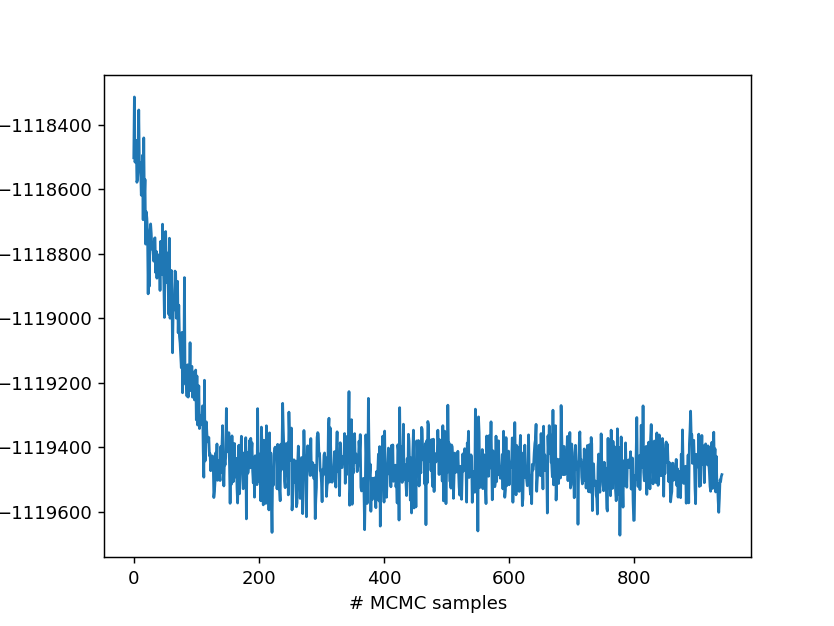

In [12]:
%matplotlib nbagg
from ensemble_hic.setup_functions import make_posterior
import matplotlib.pyplot as plt
p = make_posterior(settings)
def p_tempered(x, lammda, beta):
    p['lammda'].set(lammda)
    p['beta'].set(beta)
    return -p.log_prob(**x.variables)
energies = np.array([[p_tempered(x, schedule['lammda'][j], schedule['beta'][j]) for x in samples[j]] 
                     for j in range(n_replicas)])
fig, ax = plt.subplots()
ax.plot(energies.sum(0)[50:])
ax.set_xlabel('# MCMC samples')
ax.set_ylabel('extended ensemble energy')
plt.show()

Here, we threw away a few samples in the beginning for better visualization. Hopefully, you'll see that after a few more MCMC samples, the extended ensemble energy starts to fluctuate around some fixed value. If the Markov chain didn't get stuck in a mode, this means that it forgot it's initial state and now produces samples distributed according to the extended ensemble.

Because the last temperature values in the schedule equal to $1$, we can now extract the posterior samples as follows:

In [13]:
posterior_samples = samples[-1]

Let's throw away samples generated during the burn-in:

In [14]:
posterior_samples = samples[-1,200:]

Now we calculate the density of states (DOS) for this system:

In [15]:
from ensemble_hic.analysis_functions import calculate_DOS
dos = calculate_DOS(config_file, 50000, 10, 30000)

ImportError: No module named wham

Having calculated the DOS, we can now obtain the evidence:

In [16]:
from ensemble_hic.analysis_functions import calculate_evidence
print calculate_evidence(dos)

NameError: name 'dos' is not defined

This number alone is not too interesting, but is needed for Bayesian model comparison of, for example, statistical models differing in the number of states.

The following steps are not specific to samples obtained using RE anymore.
Let's check the distributions of gyration radii:

<IPython.core.display.Javascript object>


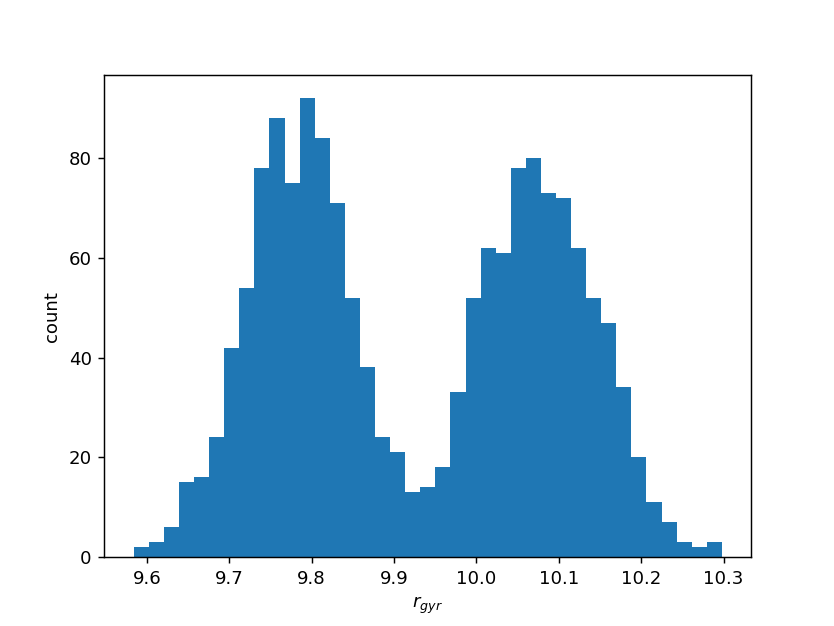

In [17]:
from csb.bio.utils import radius_of_gyration
X = np.array([x.variables['structures'].reshape(2,-1,3) for x in posterior_samples])
X_flat = X.reshape(-1,56,3)
rogs = np.array(map(radius_of_gyration, X_flat))
fig, ax = plt.subplots()
ax.hist(rogs, bins=int(np.sqrt(len(rogs))), histtype='stepfilled')
ax.set_xlabel('$r_{gyr}$')
ax.set_ylabel('count')
plt.show()

You should see a histogram with two distinct peaks. Interesting! What do these two peaks represent? Let's investigate further by calculating RMSDs to one of the ground truths, say, 1PGA, and plotting the corresponding histogram:

<IPython.core.display.Javascript object>


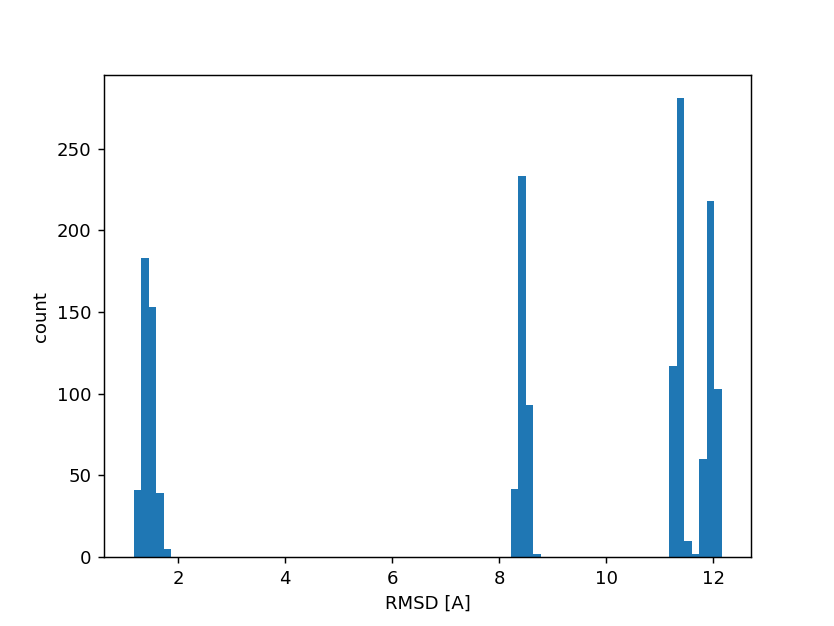

In [18]:
from csb.bio.utils import rmsd
from csb.bio.io.wwpdb import StructureParser
parser = StructureParser('../../data/proteins/1pga.pdb')
structure = parser.parse()
truth_1pga = structure.get_coordinates(['CA'])
rmsds_1pga = np.array(map(lambda x: rmsd(truth_1pga, x), X_flat))
fig, ax = plt.subplots()
ax.hist(rmsds_1pga, bins=int(np.sqrt(len(rmsds_1pga))) * 2, histtype='stepfilled')
ax.set_xlabel('RMSD [A]')
ax.set_ylabel('count')
plt.show()

Hmm. Looks like there's a bunch of structures with pretty low RMSDs to 1PGA and several (should be 3) peaks at higher RMSDs. What are the populations of these states? We'll find out with the empirical distribution function of the RMSD:

<IPython.core.display.Javascript object>


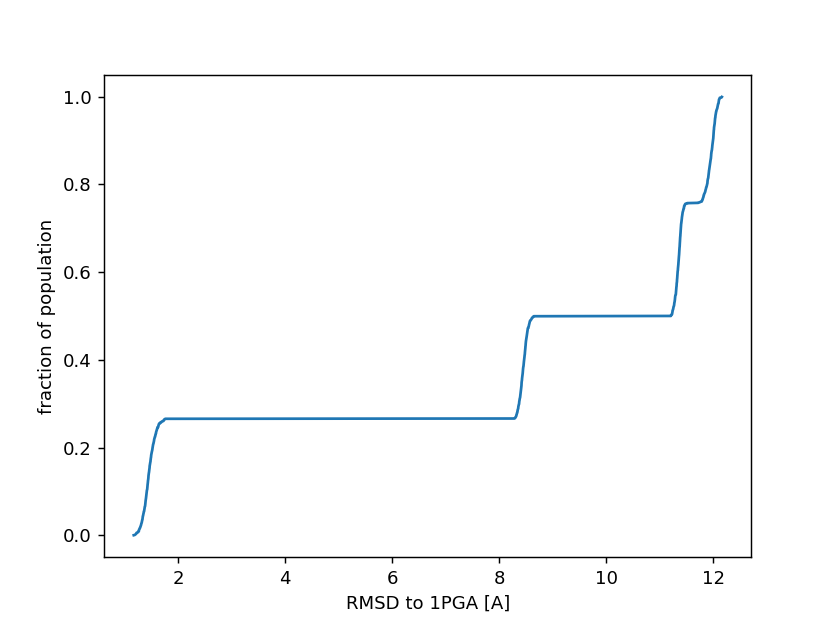

In [19]:
fig, ax = plt.subplots()
ax.plot(sorted(rmsds_1pga), np.linspace(0, 1, len(rmsds_1pga), endpoint=False))
ax.set_xlabel('RMSD to 1PGA [A]')
ax.set_ylabel('fraction of population')
plt.show()

Looks like around $25\%$ of structures have a very low RMSD to ``1pga.pdb``, the next peak in the previous histogram contributes another $25\%$ and the remaining two peaks contribute $25\%$ each.
To figure out what this means, let's take a step back and remember what we would expect: if the BIOCHROSE simulation is correct and we indeed succeed in inferring two protein structures from mixed contact data, we would expect two clusters of structures - one for each protein, right? 
No! Turns out that if you have a conformation of a polymer fulfilling a set of contact restraints, its topological mirror image fulfills the restraints equally well. Thus, for each of the two protein structures, there's two, not one, cluster of correct structures. That makes a total number of $4$ clusters with correct structures. That means there should be $4$ clusters of RMSD values. We now expect that, for good sampling, we have an approximately equal number of samples exhibiting the conformation given in the ground truth PDB file (low RMSD to ``1pga.pdb``) and its topological mirror image (high RMSD to ``1pga.pdb``). To check that this is indeed the case, we now select the $50\%$ subpopulation of structures with high RMSD, mirror them around the coordinate origin, and again calculate and plot the histogram of RMSDs to ``1pga.pdb``:

<IPython.core.display.Javascript object>


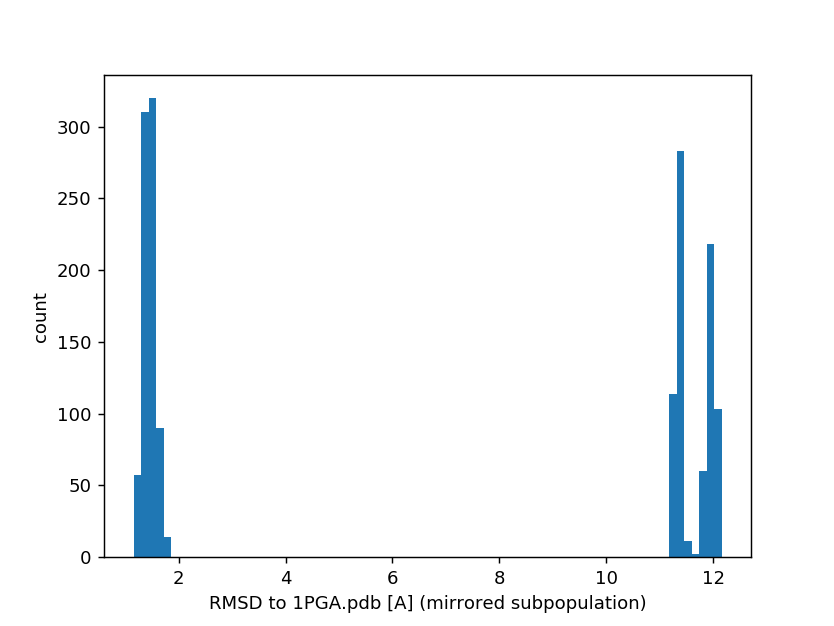

In [20]:
X_flat_mirrored = X_flat.copy()
X_flat_mirrored[np.logical_and(rmsds_1pga > 4, rmsds_1pga < 10)] *= -1
rmsds_1pga_mirrored = np.array(map(lambda x: rmsd(truth_1pga, x), X_flat_mirrored))
fig, ax = plt.subplots()
ax.hist(rmsds_1pga_mirrored, bins=int(np.sqrt(len(rmsds_1pga_mirrored))) * 2, histtype='stepfilled')
ax.set_xlabel('RMSD to 1PGA.pdb [A] (mirrored subpopulation)')
ax.set_ylabel('count')
plt.show()

We find that, after mirroring the high-RMSD $50\%$ subpopulation, this subpopulation merges with with the low-RMSD $50\%$ subpopulation, confirming that the former subpopulation indeed consisted of topological mirror images of the latter. We could now repeat this analysis with the RMSDs to ``1shf.pdb``, but would find a very similar result.

Finally, let's find the maximum *a-posteriori* (MAP) estimate and write out the corresponding structures to a PDB file:

In [21]:
from ensemble_hic.analysis_functions import write_ensemble
MAP_structures = X[np.argmin(energies[-1])]
write_ensemble(MAP_structures, '/tmp/MAP_protein_structures.pdb')

The structures are now saved in a multi-model PDB file located at ``/tmp/MAP_protein_structures.pdb`` and can visualized in PyMOL, VMD or any other PDB viewer.